# Q-Learning Algorithm in Reinforcement Learning

Reinforcement Learning (RL) is a type of machine learning where an agent learns how to make decisions by interacting with an environment. The objective of the agent is to maximize cumulative reward over time through trial and error.

Q-Learning, a model-free, value-based method within RL, allows the agent to estimate the action-value function (Q-function) and ultimately learn the optimal policy by iteratively improving its action-value estimates.

In [1]:
%%capture
# To plot pretty figures
%matplotlib inline
import math
import random
import sys

import matplotlib.pyplot as plt

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")
from collections import deque

import gymnasium as gym
import numpy as np
import pygame
import tensorflow as tf
from IPython.display import clear_output
from PIL import Image
from pygame.locals import *
from tensorflow import keras

from likelihood.models.deep import AutoClassifier


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Theoretical Foundations

### 1. **Action-Value Function (Q-function)**

The action-value function, denoted as $Q(s, a)$, evaluates the quality of a given action $a$ in a state $s$. It measures the expected cumulative reward an agent can obtain by taking action $a$ in state $s$ and thereafter following an optimal policy. The function $Q(s, a)$ is updated during the learning process to reflect the agent’s evolving understanding of its environment.

### 2. **Optimal Policy**

An optimal policy, $\pi^*$, is a strategy where the agent always selects actions that maximize its expected cumulative reward. Formally, the optimal policy is defined as:

$$
\pi^*(s) = \arg\max_a Q^*(s, a)
$$

This means that for each state $s$, the agent will choose the action $a$ that maximizes the Q-value, thereby ensuring the highest long-term reward.

### 3. **Bellman Optimality Equation**

The Bellman optimality equation defines the relationship between the Q-value of a state-action pair and the rewards that can be obtained from it. It is central to Q-Learning:

$$
Q^*(s, a) = R(s, a) + \gamma \max_{a'} Q^*(s', a')
$$

Where:
- $ R(s, a) $ is the immediate reward for taking action $a$ in state $s$.
- $ \gamma $ is the discount factor ($ 0 < \gamma \leq 1$), which determines the weight of future rewards compared to immediate rewards. A higher $\gamma$ values future rewards more heavily.

### 4. **Q-Learning Algorithm**

Q-Learning iteratively updates the action-value function based on the agent's experiences. The update rule is as follows:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Where:
- $ \alpha $ is the learning rate ($ 0 < \alpha  \leq 1$), controlling how much new information overrides the previous Q-value.
- $ R(s, a) $ is the immediate reward obtained by taking action $a$ in state $s$.
- $ \gamma $ is the discount factor, which balances immediate and future rewards.
- $ \max_{a'} Q(s', a') $ represents the maximum Q-value over all possible actions from the next state $s$.


In [2]:
# let’s define our gym environment
env = gym.make("MountainCar-v0")
# Declaring a few constants
num_episodes = 50
num_steps = 100
gamma = 0.7  # discount_factor
batch_size = 32
replay_buffer = deque(maxlen=2000)

input_shape = env.observation_space.shape[0]
num_actions = env.action_space.n


model = AutoClassifier(
    input_shape_parm=input_shape,
    num_classes=num_actions,
    units=16,
    activation="elu",
    classifier_activation="linear",
)

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.MeanSquaredError(name="mean_squared_error")


def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() > epsilon:
        if isinstance(state, tuple):
            value_function = model.predict(state[0].reshape(1, -1), verbose=0)[0]
        elif isinstance(state, np.ndarray):
            value_function = model.predict(state.reshape(1, -1), verbose=0)[0]
        action = np.argmax(value_function)
    else:
        action = np.random.choice(num_actions)
    return action


def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info, _ = env.step(action)
    done = 1 if done else 0
    state = state[0].reshape(1, -1) if isinstance(state, tuple) else state.reshape(1, -1)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info


def training_step(batch_size):
    batch_ = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch_)
    states = np.array(states).reshape(batch_size, -1)
    actions = np.array(actions).reshape(
        batch_size,
    )
    rewards = np.array(rewards).reshape(
        batch_size,
    )
    next_states = np.array(next_states).reshape(batch_size, -1)
    dones = np.array(dones).reshape(
        batch_size,
    )
    next_Q_values = model(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = rewards + (1 - dones) * gamma * max_next_Q_values

    # mask = tf.one_hot(actions, num_actions)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.gather(all_Q_values, actions, axis=1)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [3]:
rewards = []
best_loss = float("inf")
loss = float("inf")
# Training loop
for episode in range(num_episodes):
    obs = env.reset()
    sum_rewards = 0
    epsilon = max(1 - episode / int(num_episodes * 0.8), 0.01)  # Epsilon decay
    for step in range(num_steps):
        next_state, reward, done, info = play_one_step(env, obs, epsilon)
        sum_rewards += reward

        # If the buffer has enough samples, begin training
        if len(replay_buffer) > batch_size:
            loss = training_step(batch_size)

        obs = next_state  # Update current state

        if done:
            break

    # Keep track of the best model based on performance
    if loss < best_loss:
        best_weights = model.get_weights()
        best_loss = loss
        sum_rewards += 1

    rewards.append(sum_rewards)

    # Logging every 10% of episodes
    if episode % (num_episodes // 10) == 0:
        print(
            f"Episode: {episode}, Steps: {step+1}, Epsilon: {epsilon:.3f}, Loss: {loss:.6f}, Reward: {sum_rewards}"
        )


model.set_weights(best_weights)
model.save("keras_model/")

Episode: 0, Steps: 100, Epsilon: 1.000, Loss: 0.269632, Reward: -99.0
Episode: 5, Steps: 100, Epsilon: 0.875, Loss: 0.019876, Reward: -100.0
Episode: 10, Steps: 100, Epsilon: 0.750, Loss: 0.004510, Reward: -100.0
Episode: 15, Steps: 100, Epsilon: 0.625, Loss: 0.001448, Reward: -99.0
Episode: 20, Steps: 100, Epsilon: 0.500, Loss: 0.000730, Reward: -100.0
Episode: 25, Steps: 100, Epsilon: 0.375, Loss: 0.000366, Reward: -100.0
Episode: 30, Steps: 100, Epsilon: 0.250, Loss: 0.000161, Reward: -99.0
Episode: 35, Steps: 100, Epsilon: 0.125, Loss: 0.000062, Reward: -99.0
Episode: 40, Steps: 100, Epsilon: 0.010, Loss: 0.000021, Reward: -100.0
Episode: 45, Steps: 100, Epsilon: 0.010, Loss: 0.000008, Reward: -99.0


Saving figure dqn_rewards_plot


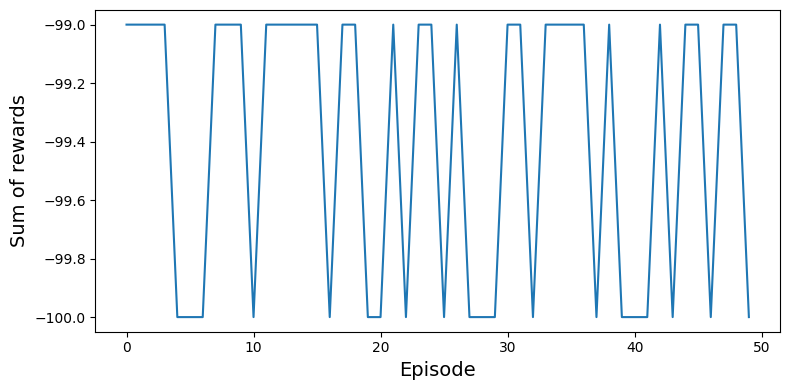

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

In [5]:
# pygame essentials
pygame.init()
DISPLAYSURF = pygame.display.set_mode((625, 400), 0, 32)
clock = pygame.time.Clock()
pygame.display.flip()

# openai gym env
env = gym.make("MountainCar-v0", render_mode="rgb_array")
input_shape = env.observation_space.shape[0]
num_actions = env.action_space.n
state = env.reset()

done = False
count = 0
steps = 0
# loading trained model
model = tf.keras.models.load_model("keras_model")


def print_summary(text, cood, size):
    font = pygame.font.Font(pygame.font.get_default_font(), size)
    text_surface = font.render(text, True, (125, 125, 125))
    DISPLAYSURF.blit(text_surface, cood)


while count < 10000:
    pygame.event.get()
    steps += 1

    for event in pygame.event.get():
        if event.type == QUIT:
            pygame.quit()
            raise Exception("training ended")
    # Get the action probabilities from the policy network
    action = epsilon_greedy_policy(state, epsilon=epsilon)
    print("state:", state)
    print("action taked:", action)
    clear_output(wait=True)
    next_state, reward, done, info, _ = env.step(action)  # take a step in the environment
    image = env.render()  # render the environment to the screen

    # convert image to pygame surface object
    image = Image.fromarray(image, "RGB")
    mode, size, data = image.mode, image.size, image.tobytes()
    image = pygame.image.fromstring(data, size, mode)

    DISPLAYSURF.blit(image, (0, 0))
    print_summary("Step {}".format(steps), (10, 10), 15)
    pygame.display.update()
    clock.tick(100)
    count += 1
    if done:
        print_summary("Episode ended !".format(steps), (100, 100), 30)

        state = env.reset()
        done = False
    state = next_state

pygame.quit()

state: [-1.0175363   0.03365551]
action taked: 2
